In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [23]:
file = 'PAM194_Keratino_CytoPanel_1\pam194ObjAllcyto'
df = pd.read_pickle(file+'.pkl')
cols = list(df.iloc[:,6:].columns)

In [24]:
features = pd.read_json('features.json')['features']
features = {list(features[i].keys())[0]:list(features[i].values())[0] for i in range(len(features))}
feature_list = list(features.keys())

In [25]:
features_in_df = []
for f in feature_list:
    if list(df.filter(regex = f)):
        features_in_df.append(f)
features_in_df

['Granularity',
 'Intensity',
 'RadialDistribution_MeanFrac',
 'RadialDistribution_ZernikeMagnitude',
 'Texture_AngularSecondMoment',
 'Texture_Contrast']

In [26]:
map_plate = {j[1]:j[0] for j in enumerate(df['Metadata_Plate'].unique())}
df['Metadata_Plate'] = df['Metadata_Plate'].map(map_plate)
plate_num = len(map_plate)

In [27]:
map_well = {j[1]:j[0] for j in enumerate(df['Metadata_Well'].unique())}
df['Metadata_Well'] = df['Metadata_Well'].map(map_well)
map_map_well = {v:k for k,v in zip(map_well.keys(), map_well.values())}

In [28]:
# in each plate, check each well
# H_0: in plate i, well_j and well_k have same distribution
df_plates = []
for i in range(plate_num):
    df_plates.append(df[df['Metadata_Plate']==i])
    # df_p1 = df[df['Metadata_Plate']==0]
    # df_p2 = df[df['Metadata_Plate']==1]
    # df_p3 = df[df['Metadata_Plate']==2]

## perform two-sample t-tests for different wells

In [29]:
wells = []
for plate in df_plates:
    wells.append(plate.groupby(by=['Metadata_Metadata_Cytokine', 'Metadata_Metadata_Dose', 'Metadata_Well']).mean().index)
# p1 = df_p1.groupby(by=['Metadata_Metadata_Cytokine', 'Metadata_Metadata_Dose', 'Metadata_Well']).mean().index
# p2 = df_p2.groupby(by=['Metadata_Metadata_Cytokine', 'Metadata_Metadata_Dose', 'Metadata_Well']).mean().index
# p3 = df_p3.groupby(by=['Metadata_Metadata_Cytokine', 'Metadata_Metadata_Dose', 'Metadata_Well']).mean().index

for each unique pair of cytokine and the dosage, perform two-sample t-test

In [30]:
def perform_ttest(plate, df_p):

    pval_plate = []
    for col in cols:
        tmp = []
        for i in range(0, len(plate), 2):
            currCyto, currDose = plate[i][0], plate[i][1]
            well1, well2 = plate[i][2], plate[i + 1][2]
            sample = df_p[df_p['Metadata_Metadata_Cytokine']==currCyto][df_p['Metadata_Metadata_Dose']==currDose]
            sample1 = sample[df_p['Metadata_Well']==well1][col]
            sample2 = sample[df_p['Metadata_Well']==well2][col]
            # print()
            tmp.append(stats.ttest_ind(sample1,sample2).pvalue)
        pval_plate.append(tmp)

    idx = []
    cytos = []
    dose = []
    for i in range(0, len(plate), 2):
        currCyto, currDose = plate[i][0], plate[i][1]
        well1, well2 = plate[i][2], plate[i + 1][2]
        idx.append(map_map_well[well1] + ' v.s.' + map_map_well[well2])
        cytos.append(currCyto)
        dose.append(currDose)
    idx = pd.Series(idx)

    pval_plate = np.array(pval_plate).T
    pval_plate = pd.DataFrame(pval_plate)
    pval_plate.columns = cols
    pval_plate['Cytokines'] = pd.Series(cytos)
    pval_plate['Dose'] = pd.Series(dose)
    pval_plate = pval_plate.set_index(idx)
    return pval_plate

In [31]:
def generate_fig(pval_plate, name):
    # plt.plot(pval_plate1.iloc[0].filter(regex = 'Texture_'))
    fig, axs = plt.subplots(nrows=pval_plate.shape[0], ncols=len(features_in_df), figsize=(40, 40), 
                            sharey=True, sharex=True)
    idx = pval_plate.index
    for j in range(pval_plate.shape[0]):
        for i in range(len(features_in_df)):
            tmp = pval_plate.iloc[j].filter(regex = features_in_df[i])
            if tmp.shape[0]:
                axs[j][i].boxplot(tmp,
                            vert=True,  # vertical box alignment
                            patch_artist=True,
                            )  # fill with color)
                
                axs[j][i].axhline(y=0.05, color='r', linestyle='-')
                # axs[j][i].set_ylabel(idx[j], rotation=270)
    for i in range(len(features_in_df)):
        axs[-1][i].set_xlabel(features_in_df[i], rotation=270)
    for j in range(pval_plate.shape[0]):
        axs[j][0].set_ylabel(idx[j] + ' ' + 
                             pval_plate.iloc[j]['Cytokines'] + ' ' + 
                             str(pval_plate.iloc[j]['Dose']), rotation=270)
    return 

see if any specific group of variables should have significantly different p-values across all variables

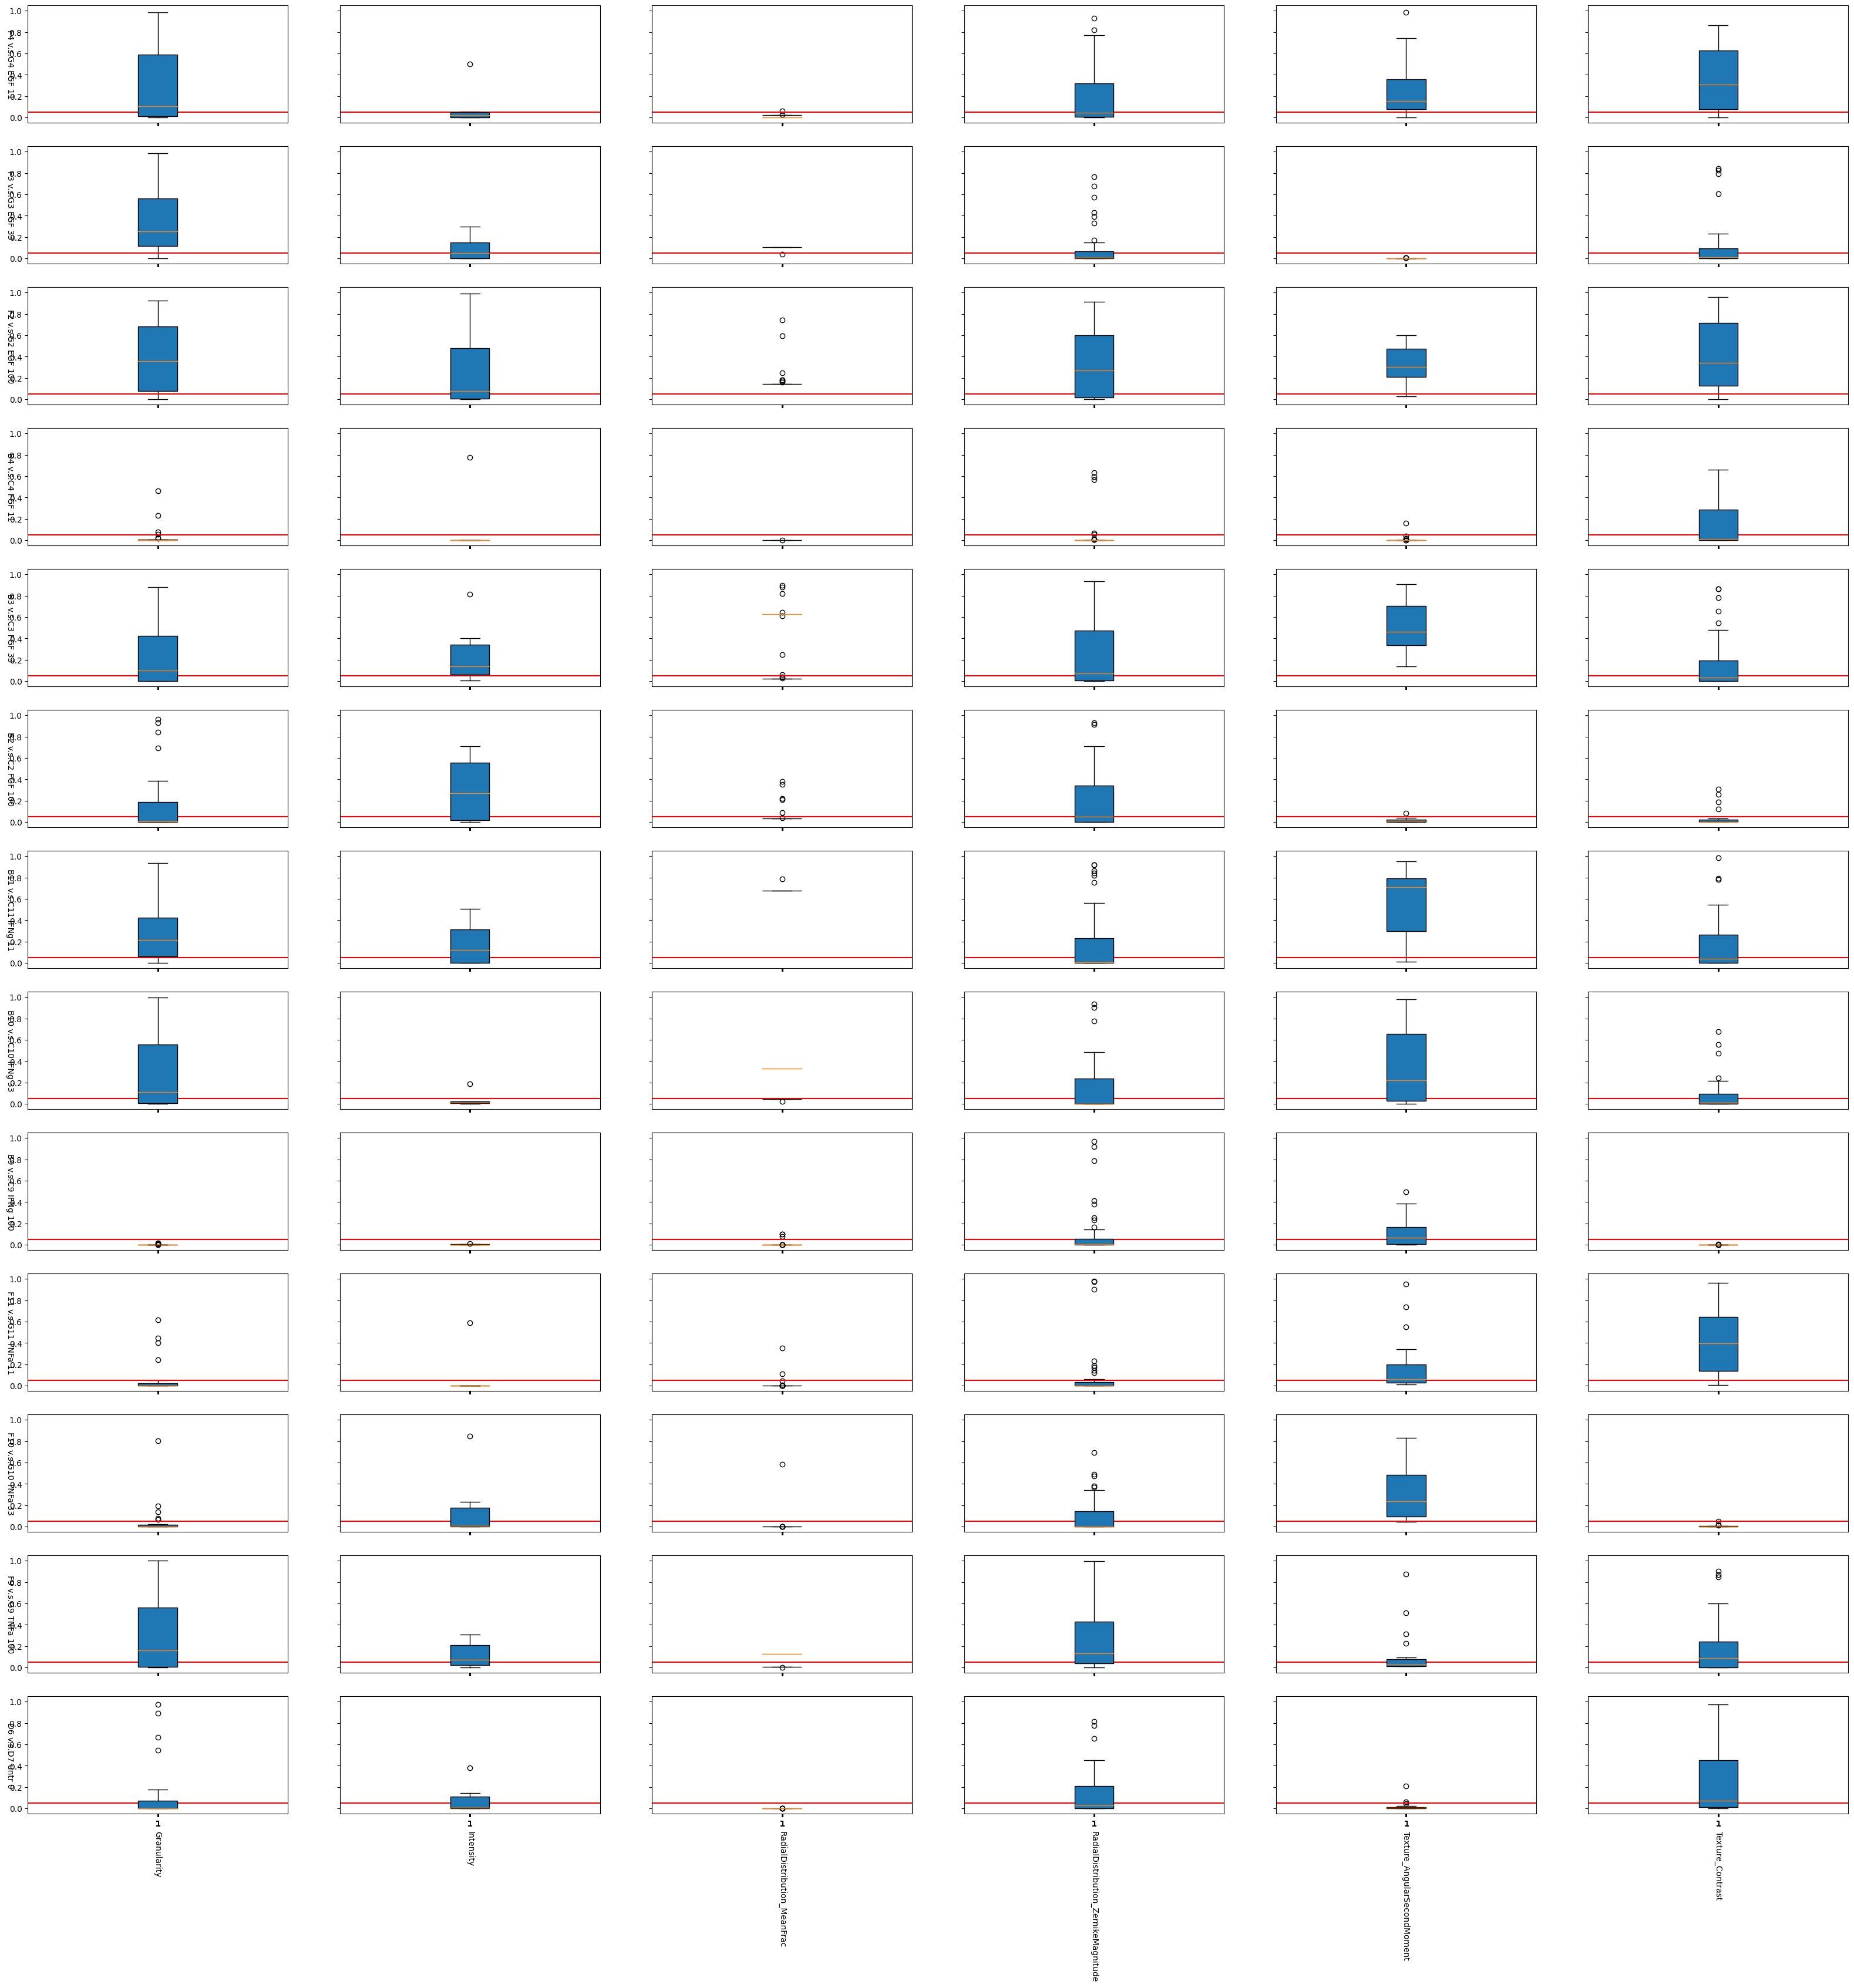

In [32]:
# pval_plate1 = perform_ttest(p1, df_p1)
pval_plate1 = perform_ttest(wells[0], df_plates[0])
generate_fig(pval_plate1, 'pval_plate1')

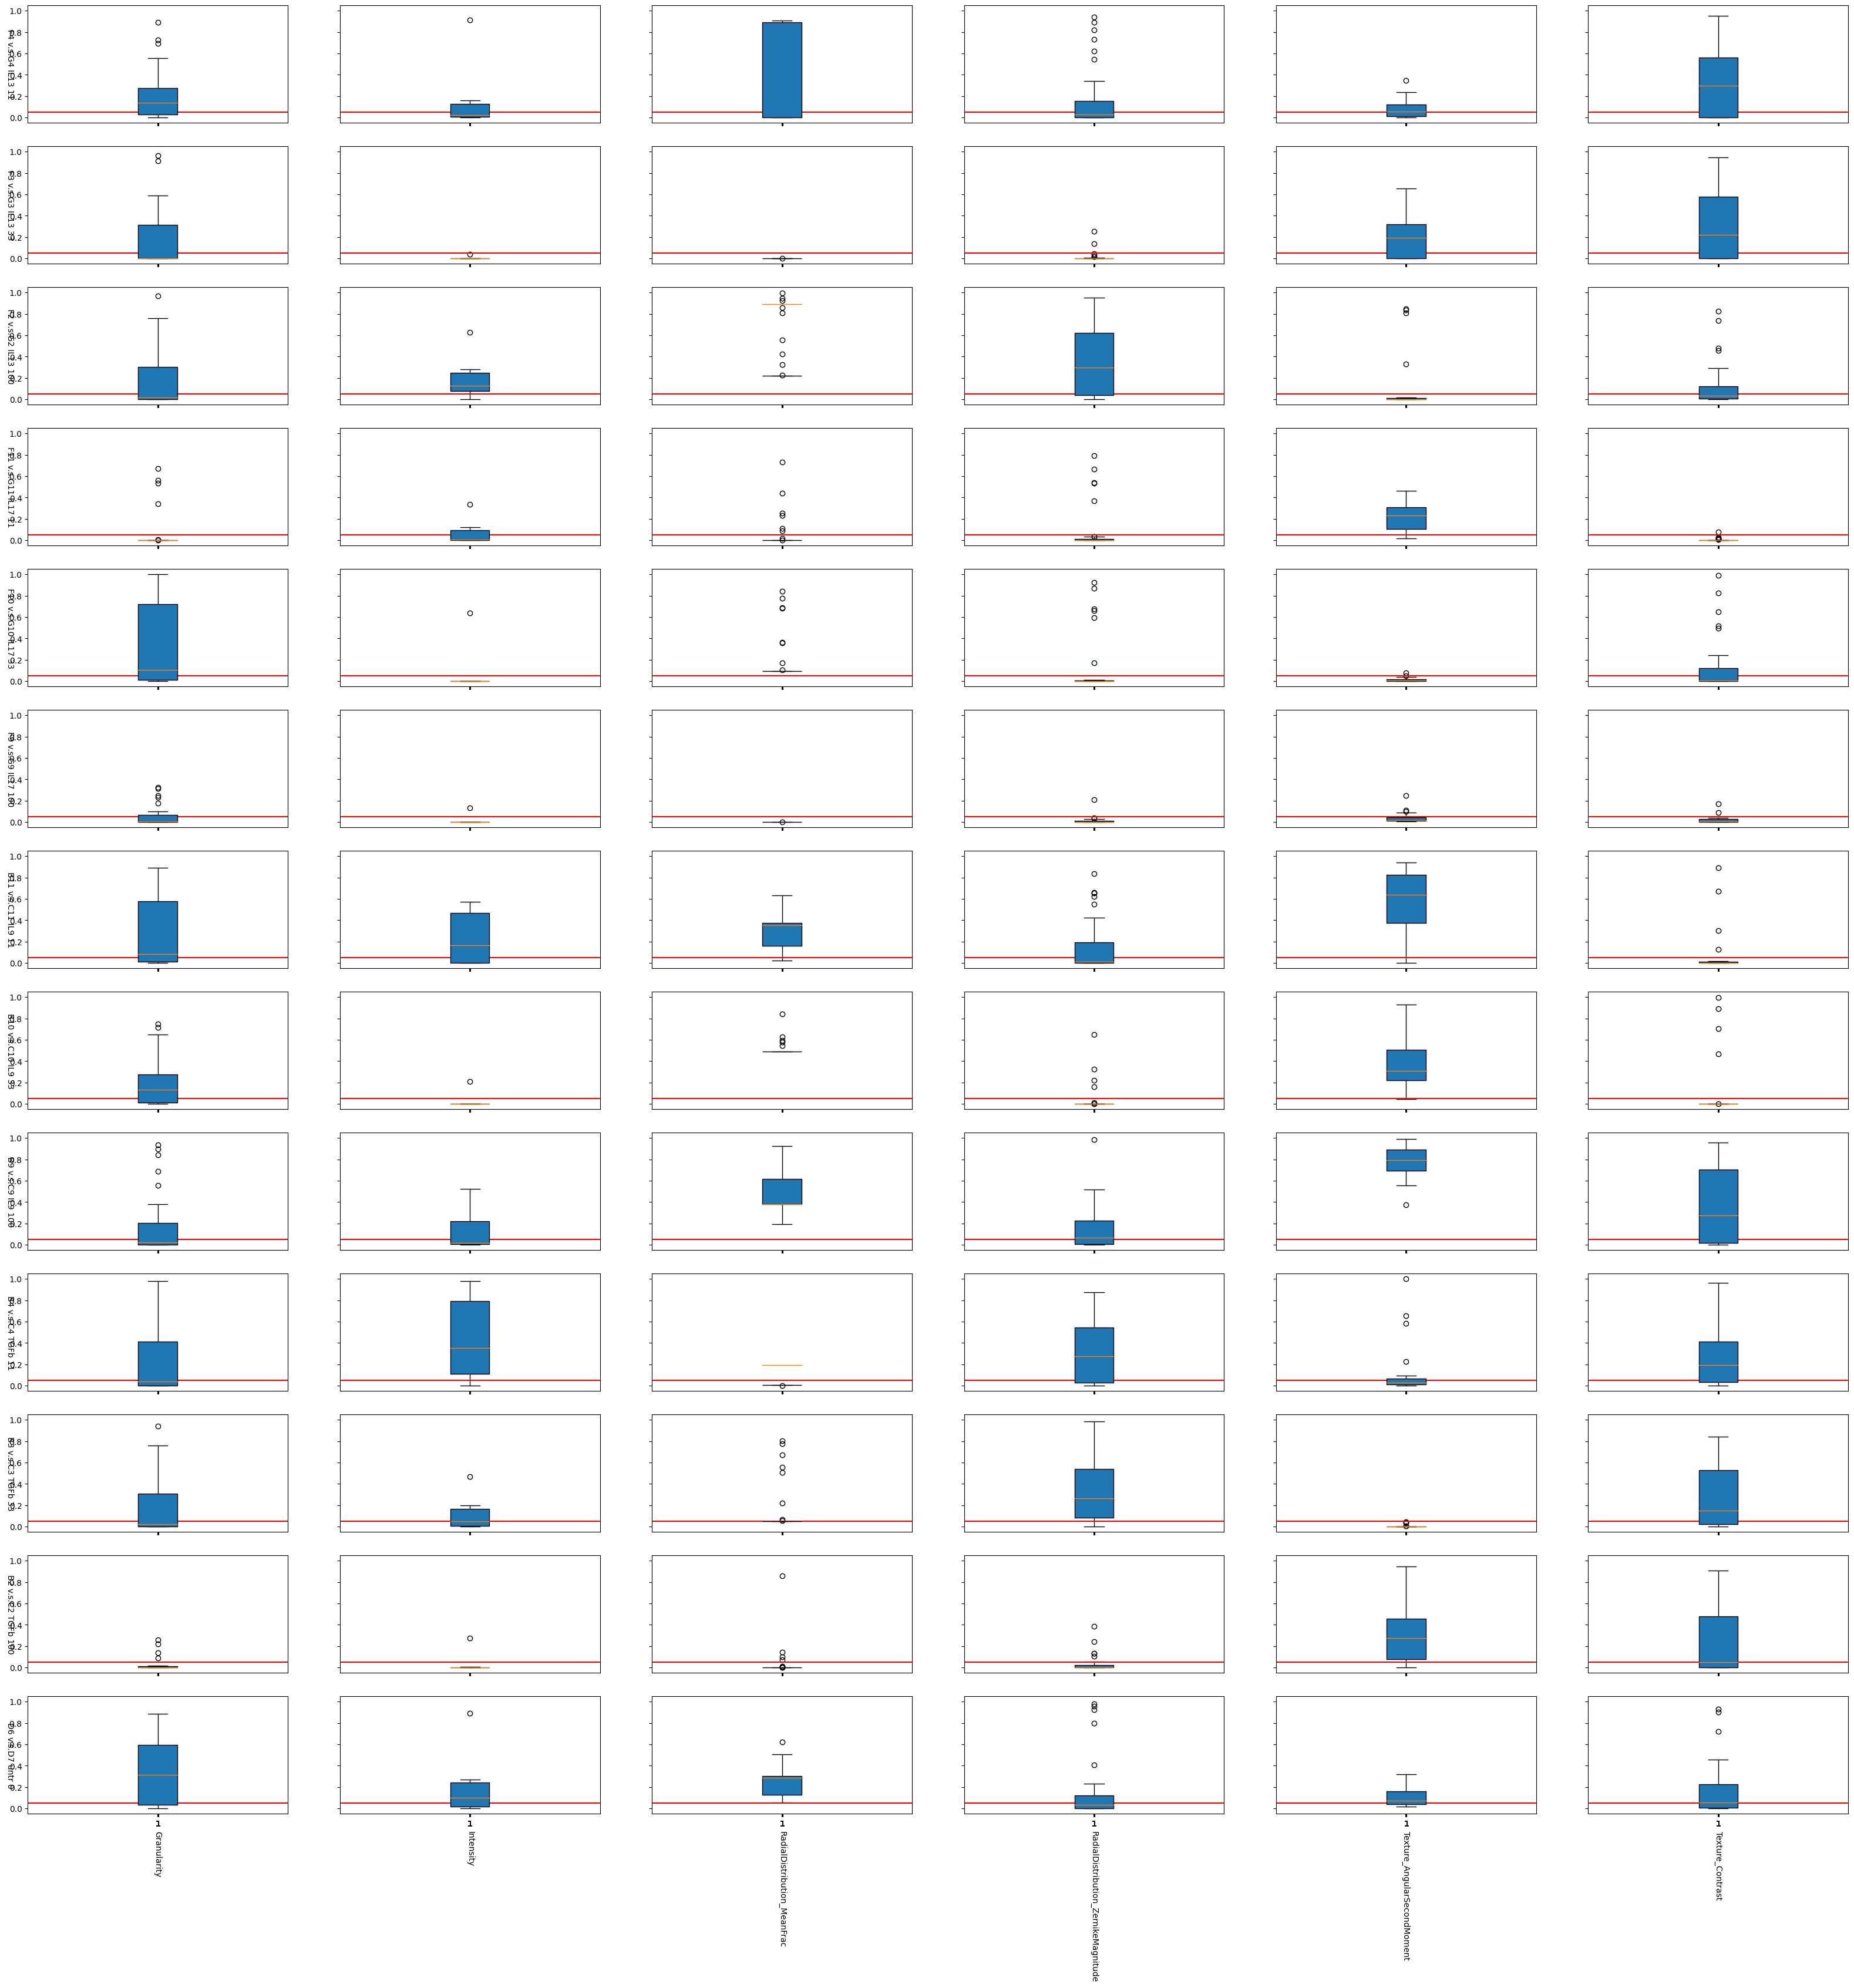

In [33]:
# pval_plate2 = perform_ttest(p2, df_p2)
pval_plate2 = perform_ttest(wells[1], df_plates[1])
generate_fig(pval_plate2, 'pval_plate2')

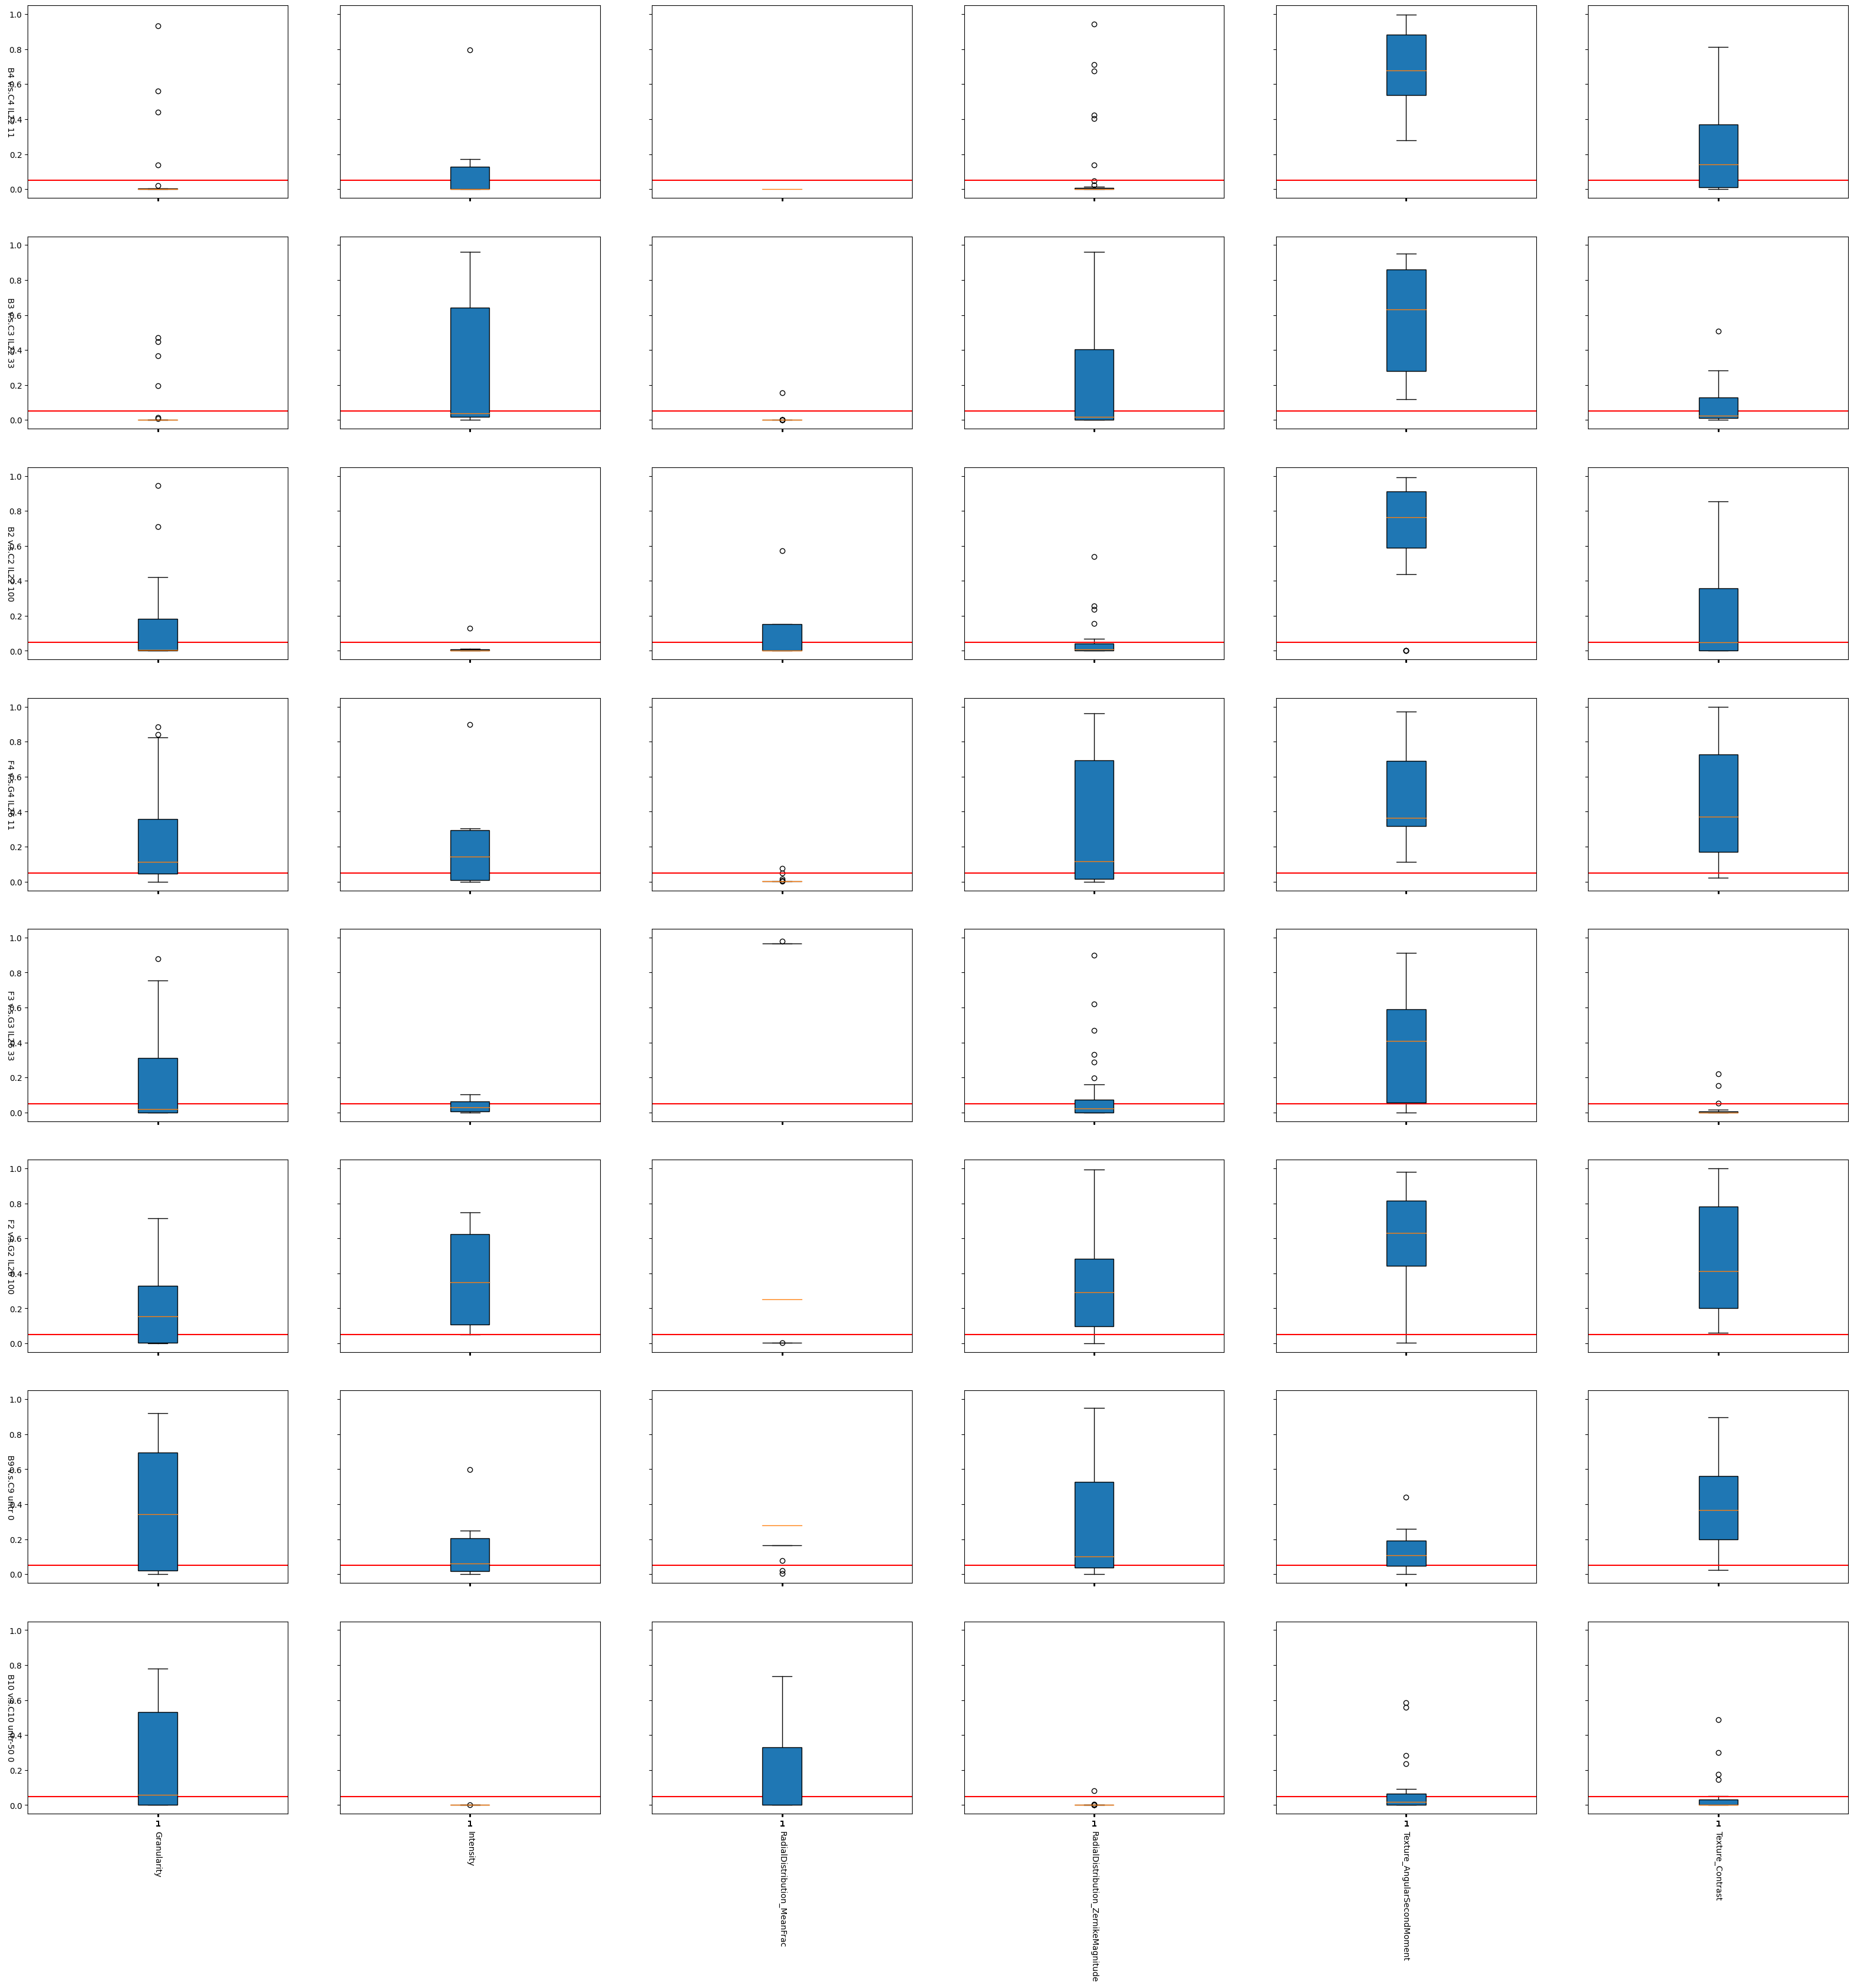

In [34]:
# pval_plate3 = perform_ttest(p3, df_p3)
try:
    pval_plate3 = perform_ttest(wells[2], df_plates[2])
    generate_fig(pval_plate3, 'pval_plate3')
except:
    pass

In [35]:
rejected_plate1 = pval_plate1.iloc[:,:-2] < 0.05
rejected_plate1 = pd.DataFrame(np.where(rejected_plate1==True, rejected_plate1, 0)).set_index(pval_plate1.index)

In [36]:
def generate_pie(plate):
    
    fig = plt.figure(figsize=(20, 16))
    if plate.shape[0] < 15:
        nrows = 3
    else:
        nrows = 5
    ncols = int(np.ceil(plate.shape[0] / nrows))
    spec = fig.add_gridspec(ncols=ncols, nrows=nrows)
    k = 0
    labels = ['Rejected', 'Failed to reject']
    
    for i in range(nrows):
        for j in range(ncols):
            name = list(plate.index)[k]
            fig.add_subplot(spec[i, j], title=name).pie([plate.iloc[k].sum(), plate.iloc[k].size - plate.iloc[k].sum()], 
                    # labels=['Rejected', 'Failed to reject']
                )
            
            k += 1
            if k == plate.shape[0]:
                plt.figlegend(labels, fontsize='xx-large')
                return

See from pie charts, for two wells that run the same experiment (same cytokines at the same dosages), the proporton of the experiments to be rejects

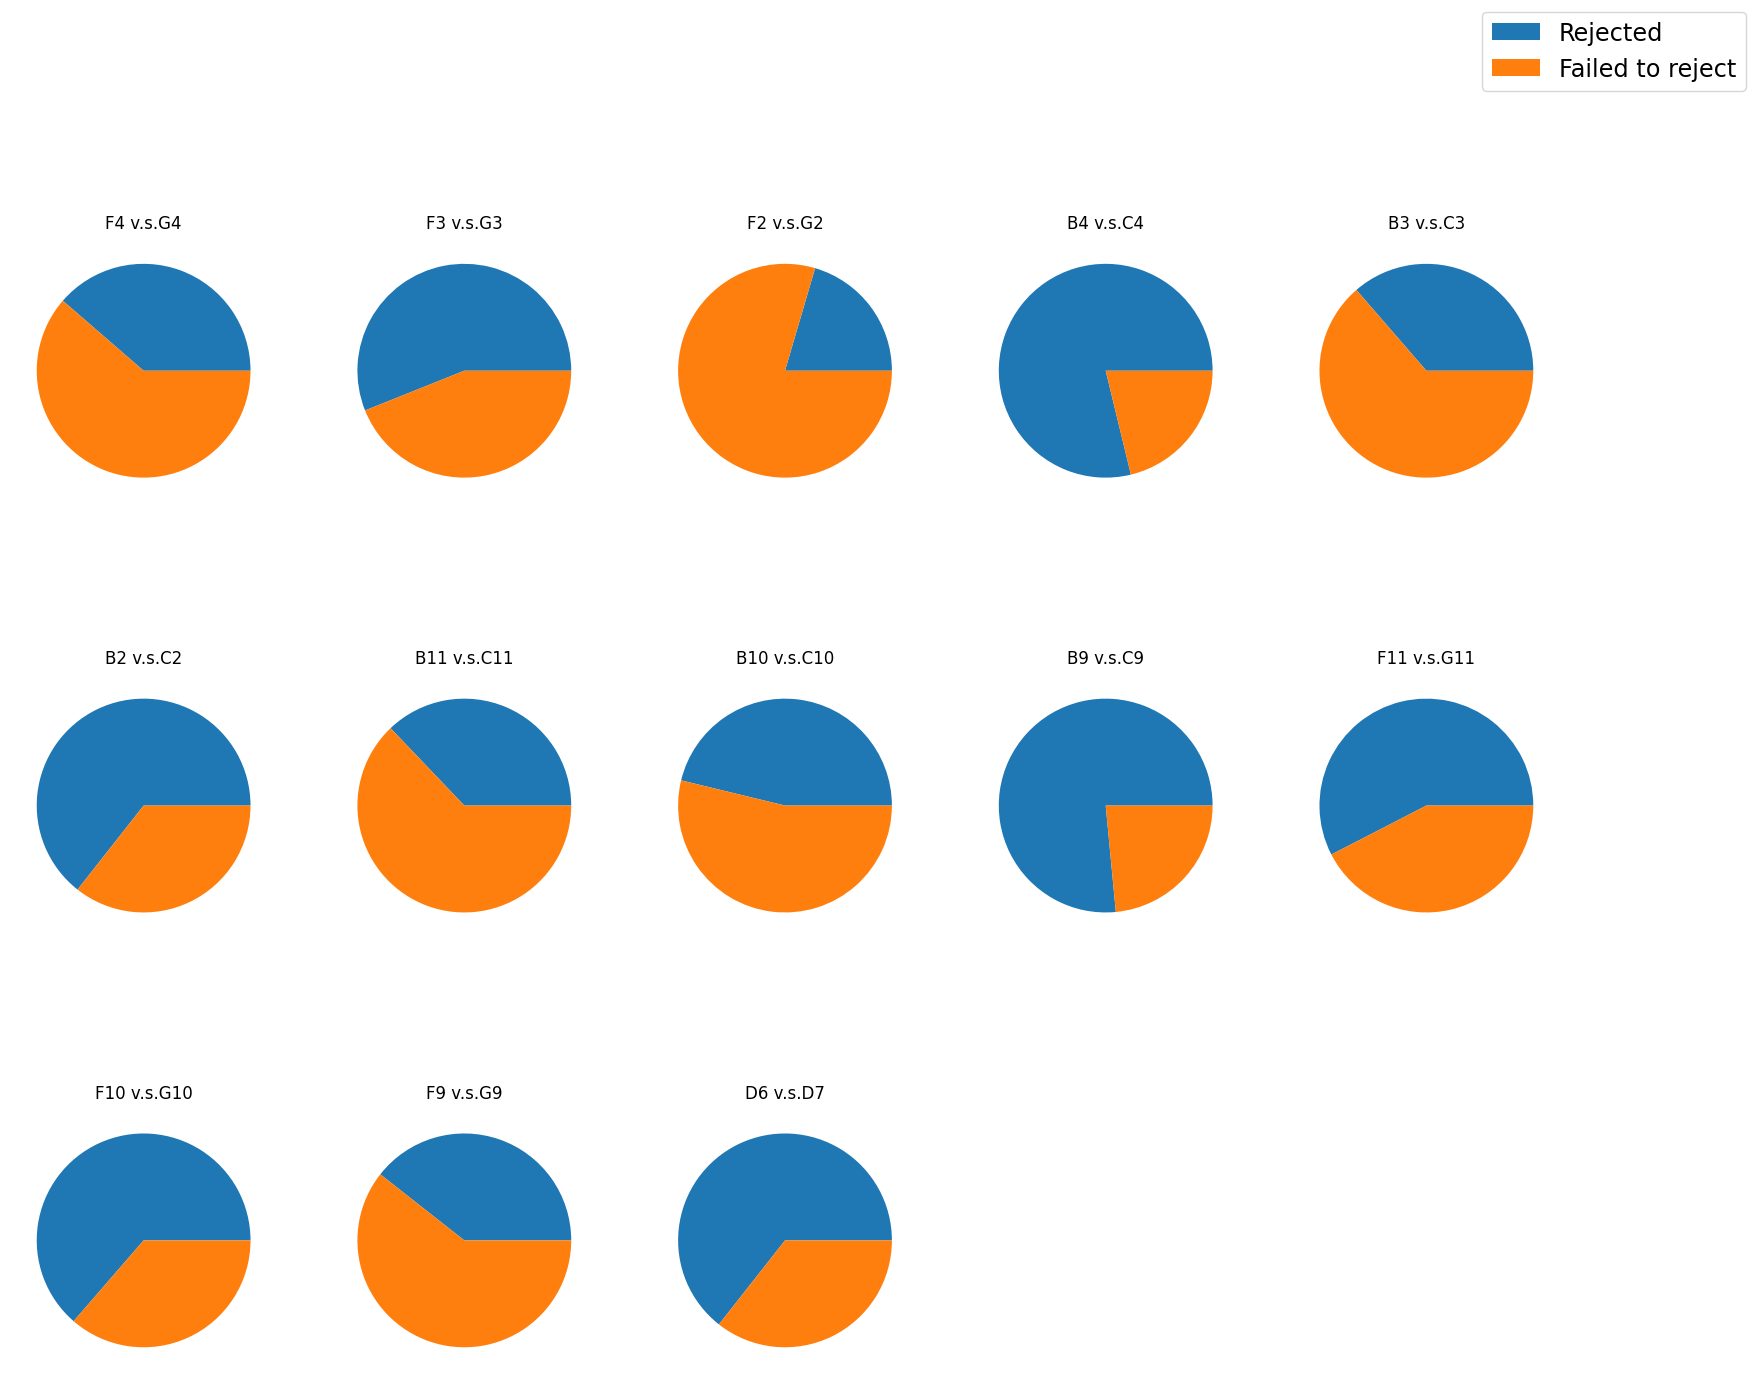

In [37]:
generate_pie(rejected_plate1)

### perform tests on plates

In [38]:
df_plates_untr = []
for plate in df_plates:
    df_plates_untr.append(plate[plate['Metadata_Metadata_Cytokine']=='untr'])
# df_p1_untr = df_p1[df_p1['Metadata_Metadata_Cytokine']=='untr']
# df_p2_untr = df_p2[df_p2['Metadata_Metadata_Cytokine']=='untr']
# df_p3_untr = df_p3[df_p3['Metadata_Metadata_Cytokine']=='untr']
# print(df_p1_untr.shape, df_p2_untr.shape, df_p3_untr.shape)

In [39]:
for plate in df_plates_untr:
      print(plate['Metadata_Well'].unique())

[12 13]
[12 13]
[ 5 11]


In [40]:
t12 = []
t13 = []
t23 = []
for col in cols:
    t12.append(stats.ttest_ind(df_plates_untr[0][col], df_plates_untr[1][col], equal_var=False)[1])
    try:
        t13.append(stats.ttest_ind(df_plates_untr[0][col], df_plates_untr[2][col], equal_var=False)[1])
        t23.append(stats.ttest_ind(df_plates_untr[1][col], df_plates_untr[2][col], equal_var=False)[1])
    except:
        pass

if t13:
    ttests = [t12, t13, t23]
    idx = ['Plate1 v.s. Plate2', 'Plate1 v.s. Plate3', 'Plate2 v.s. Plate3']
else:
    ttests = [t12]
    idx = ['Plate1 v.s. Plate2']
ttests = np.array(ttests)
ttests = pd.DataFrame(ttests)
ttests.columns = cols
ttests = ttests.set_index(pd.Series(idx))
ttests

,Granularity_1_CorrActin,Granularity_1_CorrDNA2,Granularity_1_CorrGolgi,Granularity_1_CorrMito,Granularity_1_CorrNileRed,Granularity_1_CorrWGA,Granularity_2_CorrActin,Granularity_2_CorrDNA2,Granularity_2_CorrGolgi,Granularity_2_CorrMito,...,Texture_Contrast_CorrMito_3_02_256,Texture_Contrast_CorrMito_3_03_256,Texture_Contrast_CorrNileRed_3_00_256,Texture_Contrast_CorrNileRed_3_01_256,Texture_Contrast_CorrNileRed_3_02_256,Texture_Contrast_CorrNileRed_3_03_256,Texture_Contrast_CorrWGA_3_00_256,Texture_Contrast_CorrWGA_3_01_256,Texture_Contrast_CorrWGA_3_02_256,Texture_Contrast_CorrWGA_3_03_256
Plate1 v.s. Plate2,1.765632e-18,5.653948e-51,8.469900e-08,3.047102e-01,1.725149e-54,4.883876e-08,8.067379e-55,1.112549e-18,3.338147e-55,4.821604e-16,...,1.366894e-17,2.345245e-22,8.516034e-68,3.122962e-71,2.052479e-54,8.132919e-85,1.968347e-07,3.804401e-08,3.438781e-06,3.078717e-06
Plate1 v.s. Plate3,2.503213e-82,2.178300e-79,7.400897e-40,3.623910e-23,1.864628e-159,1.321617e-27,4.147611e-23,3.065546e-59,1.855436e-17,6.659027e-80,...,2.438152e-14,1.170625e-15,3.633024e-53,1.461789e-40,9.795369e-41,6.718771e-52,3.085563e-55,8.350385e-50,7.356845e-47,6.343994e-52
Plate2 v.s. Plate3,6.511713e-162,3.340867e-225,1.142186e-17,1.957414e-21,0.000000e+00,1.225230e-09,1.956111e-06,4.579070e-130,1.351646e-102,6.756043e-156,...,3.148148e-01,3.725907e-01,1.319760e-218,2.156504e-209,2.050306e-203,1.852460e-247,2.740800e-38,6.072766e-32,1.669550e-34,3.362465e-36


In [41]:
rejected_plate = ttests.iloc[:,:-2] < 0.05
rejected_plate = pd.DataFrame(np.where(rejected_plate==True, rejected_plate, 0)).set_index(ttests.index)

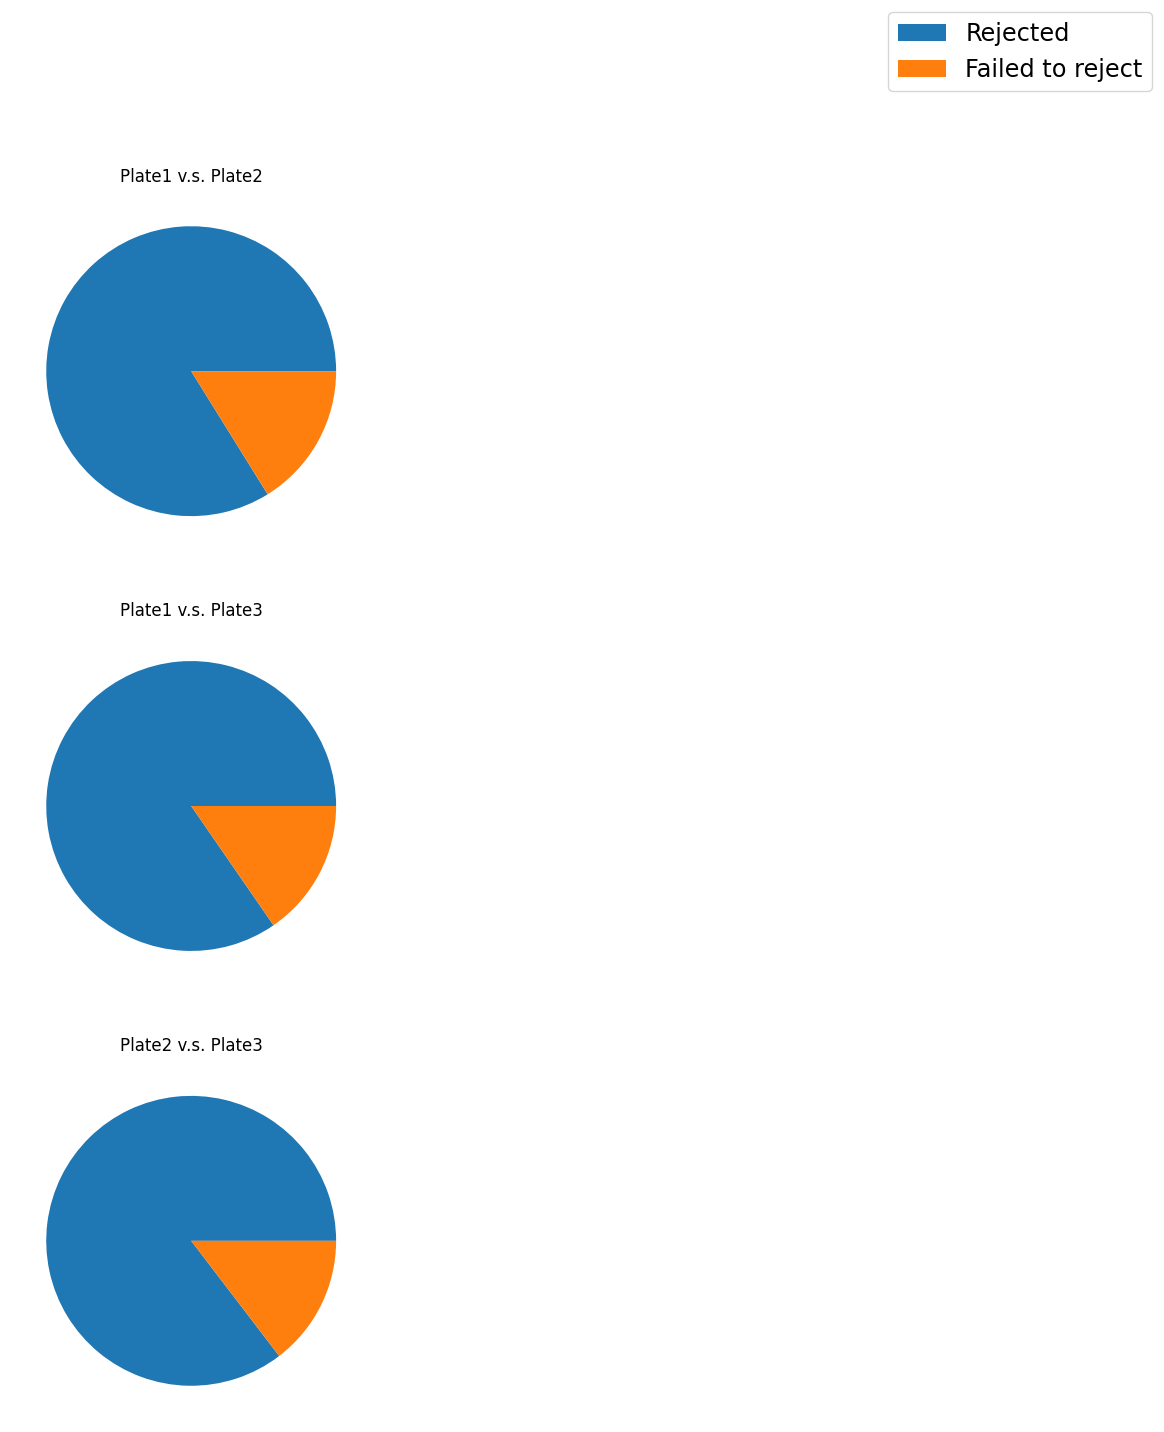

In [42]:
generate_pie(rejected_plate)